# eScience Course Report

## Group 1: Arctic - SCHMARTIC: SCHool of Model evaluation of AeRosol-Cloud inTeractions Important for Climate

### Stefan Pfaller
### stefan.pfaller@gmail.com
### eScience Course 2022, Tjärnö
### 22 November, 2022
### Assistant: Sara Blichner

## 0. Abstract

The processes leading up to the formation of clouds is complex, with many cascading effects. As clouds have a negative forcing on the radiative balance, correctly modelling these processes is considerably important in pristine environments such as the Arctic. In this report we attempt to evaluate the model not solely on the basis of the overall mass and number of particles, but target the processes leading to aerosol formation. This is done by evaluating the role of sulphate and sea salt as aerosol sources, comparing NorESM values to measured observations at the Zeppelin station in Ny-Ålesund. The influence of both of these on aerosol concentrations are overestimated. However, due to the aerosol properties in the model underestimating sulphate, not enough particles are present. This is particularly true on days with high concentrations of sulphate. High sea salt concentrations paired with a lack of particles, resulted in the model producing particles larger than would be expected. This causes clouds to form earlier in NorESM with different characteristics to correctly modeled clouds, thereby changing the overall radiative balance for the Arctic.

## 1. Introduction

Predicting Earth's changing climate is a vital need that requires models providing accurate and trustworthy expectations of future conditions, so that actions may be taken to avoid adverse scenarios . This is most true in the Artic where temperatures have been increasing at up to three times the average global rates (Serreze and Barry, 2011) . Many positive feedback loops are leading to increased warming, for example increased temperatures leading to lower sea ice cover, causing lower average surface albedo, in turn leading to further warming via decreased reflected solar radiation (Screen and Simmonds, 2010) . Other feedbacks are negative and slow the warming of the Arctic. For example, increased temperatures lead to increased evaporation, the higher relative humidity of the air causes more condensation and cloud formation, leading to more reflection of solar radiation, leading to increased cooling. Clouds' cooling effect as they reflect and scatter more light is also a forcing when observed from the perspective of aerosol concentration. Modelling these clouds correctly is very important in painting a clearer picture for the future of a rapidly changing Arctic.

The microphysical properties of clouds such as the cloud droplet size, droplet number concenrtation, and water vs ice crystal characteristics are integral in them being either net warming or net cooling . This is a large challenge to model accurately and consistently. Even when using the same sets of models, cloud feedbacks can be drastically different depending on the conditions portrayed. This was shown when, using CMIP5 models, Pithan and Mauritsen (2014) found arctic clouds to have a slight positive feedback, whilst Zelinka et al. (2013) showed Arctic clouds to have a negative feedback despite using the same set of models. An element that influences these cloud properties is the number and composition of aerosol particles forming the cloud (Mauritsen et al., 2011). Cloud condensation nuclei (CCN) are essential to properly modelling cloud properties because each droplet in the atmosphere is formed around a CCN. 

The growth of cloud droplets depends on whether it would be energetically favorable for the water to condense onto the particle or not. This depends on the supersaturation in the air as well as the particle itself. A large particle, assuming that it is soluble, provides an ideal site for water to adhere and form a cloud droplet. This is due to the solute effect, as water binds to the particle, the aerosol particle will dissolve into the water making it less likely for the water to evaporate again. Additionaly, the Kelvin effect is also working in favor of larger aerosol particles. The Kelvin effect states that water can more easily evaporate from a curved surface rather than a flater one since the hydrogen bonding present between water molecules is stronger below the flater surface. This means that in regards to aerosol particles, a larger particle will be less curved than a smaller particle. Due to these two effects working in unison, one based on particle size (Kelvin) and the other working on particle composition (Solute), the super saturation needed to activate a particle in different for every particle. Because of this, CCN's are usually defined as the particles that have the potential to be activated at a given super saturation. A low super saturation would mean that only large particles could be activated, whilst a high super saturation would result in smaller particles also potentially being activated, therefore the smaller particles are also considered CCN's in this case.

The number of aerosol particles above the size of 50 and 100 nanometers (N50 and N100 respectively), can be used as a proxy of CCN concentrations. N100 being a better proxy for when the super saturation is lower, and N50 for when the super saturation is higher. In the Arctic, where the number of aerosols present can be limiting (Mauritsen et al., 2011), the creation of aerosols is highly influencial on the formation and properties of clouds. This is because having more particles will lead to there being a higher number of smaller cloud droplets, which will be more reflective as they have a higher albedo than large cloud droplets. Sulphate is important in coating insoluble aerosols in order to make them soluble, aiding in new particle formation and aerosol size growth. Sea Spray is another significant source of aerosol particles in the arctic. As their size is quite large, in the accumulation mode, they are important for developing clouds. 

Models have become complex enough to simulate subtle aspects of Earth's atmosphere such as the source and size of aerosols, as well as atmospheric processes which lead to cloud formation. However, due to the complex nature of these interactions, it is necessary to evaluate how accurately models portrait the concentrations of these aerosol species that form the base of the cloud formation process. This is especially true in the Arctic where the clean, low - aerosol conditions make any uncertainties more significant. Furthermore, once the model calculates the radiative forcing of clouds, the strong amplifying from feedback loops make their resulting deviations from real life observations even stronger. This investigation aims to do this, assessing the accuracy of the Norwegian Earth System Model (NorESM) by comparing its results to observation data, using the Zeppelin weather station in Ny-Ålesund as the study site. 

***

## 2. Methods

#### 2.1 Importing packages

Packages used for importing, processing and ploting data:

In [2]:
!pip install threddsclient
import threddsclient
import s3fs
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

  Using cached threddsclient-0.4.2-py3-none-any.whl


**Ignoring warning to clean up the report.**

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### 2.2 Data 

Model data used in this investigation was sourced from two nudged NorESM runs. The nudging was done with regards to wind field and surface pressure to match ERA-Interim reanalysis data. This was done in order to more easily be able to compare it to measured observations. The nudging means that in the model, the circulation patterns are expected to match those in real life. This allows us to attribute any differences between model and observation data to errors in the emission datasets or processes representation in the model (Lin et al., 2016).  The first simulation is from 2012-2015, which uses observated sea surface temperature and sea ice extent. The second run from 2015 until 2018 uses sea surface temperature and sea ice from a historical run.

In this report, we use the model output of N50, N100, Black carbon (BC) as well as several types of Sulphate and Sea Salt (SS) species, which were combined into a total sulphate  and SS concentrations respectively, for the sake of this investigation. N50 and N100 are the number of particles above the size of 50 and 100 nanometers respectively.

In [4]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [5]:
#Creating path to 2012-2015 Model run data
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_full/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc'

#Selecting the variables 
varl = ['N100','N200','N50', 'BC_AI', 'SS_A1','SS_A2','SS_A3','SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC','SO4_PR']

#Dataset for 2012 data
def make_file_path_for_var(v,):
    return path_to_data+v+postfix
filelist = [make_file_path_for_var(v) for v in varl]
list_of_s3_obj = [s3.open(s) for s in filelist]
ds2012 = xr.open_mfdataset(list_of_s3_obj)

#Creating path to 2015-2018 Model run data
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

#Dataset for 2015 data
filelist = [make_file_path_for_var(v) for v in varl]
list_of_s3_obj = [s3.open(s) for s in filelist]
ds = xr.open_mfdataset(list_of_s3_obj)

#Removing overlap and Merging the datasets
ds2012= ds2012.sel(time= slice('2012-01-01','2014-12-31'))
ds = xr.merge([ds2012,ds])

#Creating a sum of all Sea Salt (SS_Model) and all Sulphate (SO4_Model)
ds['SS_Model'] = 0
ds['SS_Model'] = ds['SS_Model'] + ds['SS_A1'] + ds['SS_A2'] + ds['SS_A3']
ds['SS_Model'].attrs['units'] ='kg/kg'

ds['SO4_Model'] = 0
ds['SO4_Model'] = ds['SO4_Model'] + ds['SO4_NA'] + ds['SO4_A1'] + ds['SO4_A2'] +  ds['SO4_AC'] + ds['SO4_PR']
ds['SO4_Model'].attrs['units'] ='kg/kg'

Units of sulphate and SS concentrations were converted to be comparable with observation data. This was done assuming standard atmospheric conditions (pressure = 100000 Pa and 273.15 K).

In [6]:
T_standard =  273.15 #K
p_standard = 1e5 #Pa
R = 287.058

rho = p_standard/(R*T_standard)

var = 'SO4_Model'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'

var = 'SS_Model'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'

#Obtaining daily values to reduce outliers
ds_daily = ds.resample(time='d').mean('time')
ds_daily['season']= ds_daily['time.season']

Observation data from Zeppelin was obtained from the open source EBAS Catalogue. N50 and N100 valus were calculated from DMPS data, performing a numerical integration above the appropriate particle diameter. The sulphate and sea salt concentrations are filter pack data. All of the data was sampled daily, however since it was measured and timestamped at 19:00, this data was also resampled in order to perform further analysis. For both kinds of data, multiple timeseries were combined to overlap with the modeling data available. After being combined, the dmps data is from 1993 until 2022. The dmps data on the other hand lasts from 2000 until 2020.

In [7]:
all_opendap_urls = threddsclient.opendap_urls(
'https://thredds.nilu.no/thredds/catalog/ebas/catalog.xml')

# Importing the data
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.19930101070000.20210421112338.filter_3pack..aerosol.18y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_SUL = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20110101070000.20210420142507.filter_3pack...1y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2011 = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20120101070000.20210421112338.filter_3pack...6y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2012 = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20180101070000.20220405123416.filter_3pack...4y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2018 = xr.open_dataset(opendap_urls)

#Singling out Sulphate and Sea Salt from data
dsmf_Sul = xr.Dataset()
dsmf_fixtime= xr.Dataset()
dsmf_fixtime_Salt = xr.Dataset()
dsmf_salt = xr.Dataset()
dsmf_fixtime['SO4'] = xr.concat([dsmf_SUL['sulphate_total_ug_per_m3'],dsmf_S2011['sulphate_total_ug_per_m3'],dsmf_S2012['sulphate_total_ug_per_m3'],dsmf_S2018['sulphate_total_ug_per_m3']],dim = 'time')
dsmf_fixtime_Salt['SS'] = xr.concat([dsmf_SUL['sodium'],dsmf_S2011['sodium'],dsmf_S2012['sodium'],dsmf_S2018['sodium']],dim = 'time')

#Values were samples at 19:00, resampling at 00:00 resolves any conflict when plotting
dsmf_Sul = dsmf_fixtime.resample(time='d').mean('time')
dsmf_salt = dsmf_fixtime_Salt.resample(time='d').mean('time')


# get all data urls for one station, e.g., Zeppelin NO0042G
opendap_urls = [x for x in all_opendap_urls if 'NO0042G' in x]
# get all scattering data urls
opendap_urls = [x for x in opendap_urls if 'particle_number_size_distribution' in x]
opendap_urls = [x for x in opendap_urls if 'lev2' in x]

dsmf00 = xr.open_mfdataset(opendap_urls[3:4])
dsmf06 = xr.open_mfdataset(opendap_urls[2:3])
dsmf08 = xr.open_mfdataset(opendap_urls[:1])
dsmf10 = xr.open_dataset('../../../Data/dNdlogD_data_dmps_cleaned_2010-2020.nc')

#Values are hourly, resampling in order to get daily values
daily2000 = dsmf00.resample(time='d').mean('time')
daily2006 = dsmf06.resample(time='d').mean('time')
daily2008 = dsmf08.resample(time='d').mean('time')
daily2010 = dsmf10.resample(time='d').mean('time')

N50 and N100 values were calculated using a numeric integration of the number particle size distribution curves for sampling time.

In [8]:
from Sizedist_Util import compute_Nx_ebas_cleaned

ds_Nx_2000 =xr.Dataset()
ds_Nx_2000['N50'] = compute_Nx_ebas_cleaned(daily2000, x=50)
ds_Nx_2000['N100'] = compute_Nx_ebas_cleaned(daily2000, x=100)

ds_Nx_2006 =xr.Dataset()
ds_Nx_2006['N50'] = compute_Nx_ebas_cleaned(daily2006, x=50)
ds_Nx_2006['N100'] = compute_Nx_ebas_cleaned(daily2006, x=100)

ds_Nx_2008 =xr.Dataset()
ds_Nx_2008['N50'] = compute_Nx_ebas_cleaned(daily2008, x=50)
ds_Nx_2008['N100'] = compute_Nx_ebas_cleaned(daily2008, x=100)

ds_Nx_2010 =xr.Dataset()
ds_Nx_2010['N50'] = compute_Nx_ebas_cleaned(daily2010, x=50, var_diam = 'diameter', v_dNdlog10D='dNdlogD')
ds_Nx_2010['N100'] = compute_Nx_ebas_cleaned(daily2010, x=100, var_diam = 'diameter', v_dNdlog10D='dNdlogD')

#There is one day of overlap between the 2008 and 2010 data so this was removed before concatenating.
ds_Nx_2011 = ds_Nx_2010.sel(time=slice('2011-01','2020-12'))
ds_Nx_all = xr.concat([ds_Nx_2000, ds_Nx_2006, ds_Nx_2008, ds_Nx_2011], dim = 'time',coords='minimal',compat='override')

ds = xr.merge([dsmf_Sul.sel(time=slice('2000-03','2020-12')),ds_Nx_all,dsmf_salt.sel(time=slice('2000-03','2020-12'))])
ds['SO4'].attrs['Units'] = 'ug/m$^3$'
ds['N50'].attrs['Units'] = 'N50'
ds['N100'].attrs['Units'] = 'N100'
ds['SS'].attrs['Units'] = 'ug/m$^3$'

In order to make realistic comparisons with the observation data, the bottom layer of the NorESM model in Zeppelin was extracted from the rest of the data. Thi was done since NorESM is uses a hybrid pressure layer model so the bottom layer follows the surface topography to some extent.

In [9]:
#Selecting only Zeppelin station and data from the bottom pressure layer
Model_ds = ds_daily.sel(location='Zeppelin').isel(lev = -1)

#Renaming variables to avoid conflicts
Model_ds['N50_Model'] = Model_ds['N50']
Model_ds['N100_Model'] = Model_ds['N100']
Model_ds = Model_ds.drop_vars(['N50','N100'])

#Combining the observation and Model data
ALLDATA = xr.merge([ds,Model_ds])

In [10]:
ALLDATA = ALLDATA.load()

Defining seasons and months, in order to group by these categories and establish any potential temporal trends.

In [11]:
ALLDATA['Season'] = ALLDATA['time.season']
ALLDATA['Month'] = ALLDATA['time.month']

***

## 3. Results 

### 3.1 Particle formation processes

In order to determine the influence of sulphate on particle number, daily values of SO4 was plotted against N50 (Figure 1). This was done for observation data as well as NorESM data, with the observation data in blue, whilst the NorESM data is in yellow. The model shows a stronger correlation between the two variables than the observations. A linear regression was done for both sets of data, the resulting lines had slopes of 293.8 and 122.5 for the NorESM and observation data respectively. At first glance, these regressions look as if the fit is higher than it should be because of the fact that any outliers/points above the line will have a strong pull.  Since the data is presented in logspace, the points below the line would be very close to the line of best fit. At low concentrations, it would not be expected for the concentrations to be determined by sulphate. The difference in the slope of both lines suggests that in the arctic, the model estimates the influence of SO4 on small particles formation to be greater than it is in real life.

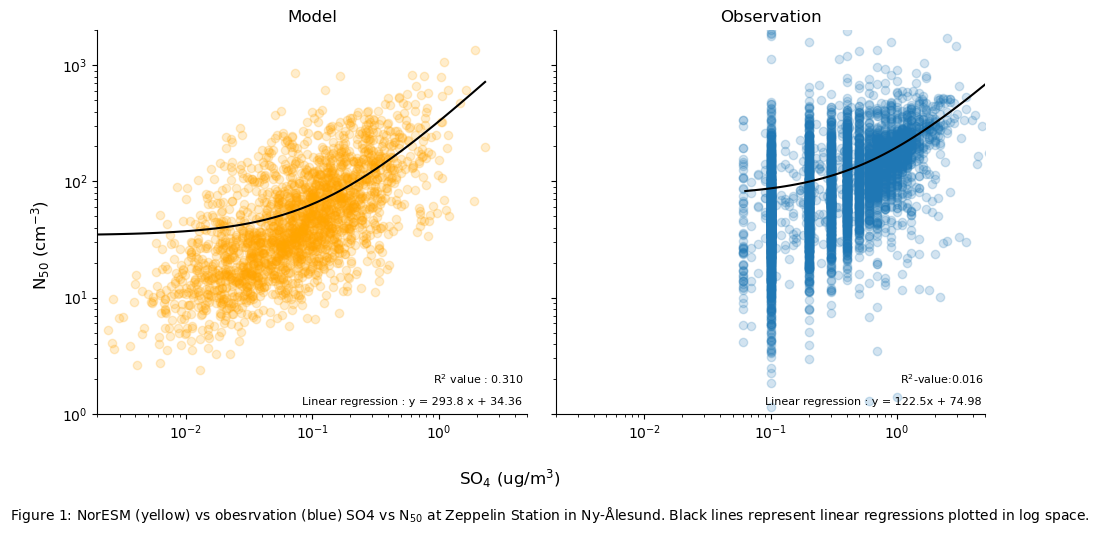

In [74]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SO4_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1.2, 'Linear regression : y = 293.8 x + 34.36' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
ax1.text(0.9, 1.8, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N50']].dropna('time')
ax2.scatter(x=_dss['SO4'], y=_dss['N50'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'], _dss['N50'], 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].max()))
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 1.2, 'Linear regression : y = 122.5x + 74.98' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'])
r_sq = model.score(x, _dss['N50'])
ax2.text(1.05, 1.8, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(1,2000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
ax2.set_title(f'Observation')
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 1: NorESM (yellow) vs obesrvation (blue) SO4 vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

Figure 2 shows the same relationship as figure 1 for SO4 now plotted against N100. In this figure, the slopes of both linear regressions appear to be very similar.  This is very different from N50, where the model overestimates the influence of sulphate. There are likely other factors that influence the concentrations of smaller particle hence why the relationship of N50 to SO4 is very inaccurate, whilst the relationship of N100 to SO4 is very accurate in the model. Additionally, when comparing sulphate to N50 as well as N100, the R-squared values of the Model data is far better than the observation data meaning a better fit between the two variables. This is due to the fact that the measured filter data could only be analyzed to a resolution of 0.1 ug/m$^{3}$ for most of the data available (Supplementary figure 1), only at the start of 2020 were instruments with a higher resolution installed.

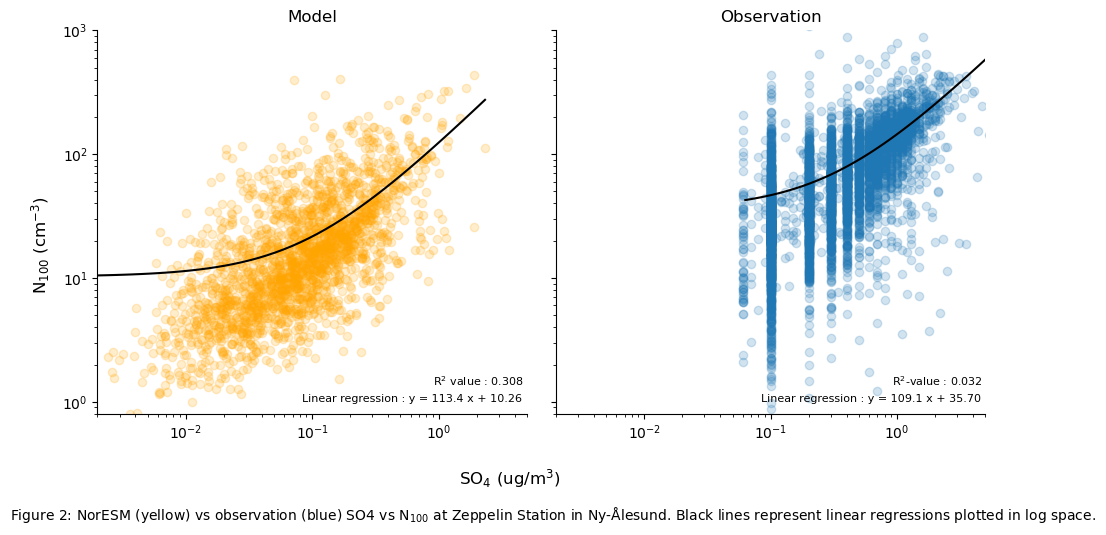

In [73]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))

_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1, 'Linear regression : y = 113.4 x + 10.26' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
ax1.text(0.9, 1.35, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N100']].dropna('time')
ax2.scatter(x=_dss['SO4'], y=_dss['N100'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'], _dss['N100'], 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].max()))
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.084, 1, 'Linear regression : y = 109.1 x + 35.70' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'])
r_sq = model.score(x, _dss['N100'])
ax2.text(0.92, 1.35, f"R$^2$-value : {r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.8,1000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
ax2.set_title(f'Observation')
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{100}$ (cm$^{-3}$)')
f.text(0, -0.05,
         'Figure 2: NorESM (yellow) vs observation (blue) SO4 vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

As seasalt is one of the largest sources of aerosols, especially in a pristine region like the Arctic, it might also have an important role in the model's sources of N50 and N100 values. Figure 3 presents the relationship between the concentrations of sea salt and N50 in both the model (yellow) and observations (blue). The r-squared value here too is increadibly low for the observation data due to the striation present, notably at low concentrations. The line of best fit for the model shows a 6.0 times lower relationship of N50 particles to sea salt than is present in the observation data. For the observation data there are most data points clustered around median concentrations of Sea salt (0.14 ug/m3). In the model data however, the spread of the sea salt concentrations is far higher. The lower spread as well as the striation in the observation data also result from a low instrument resolution, as mentioned for SO4.

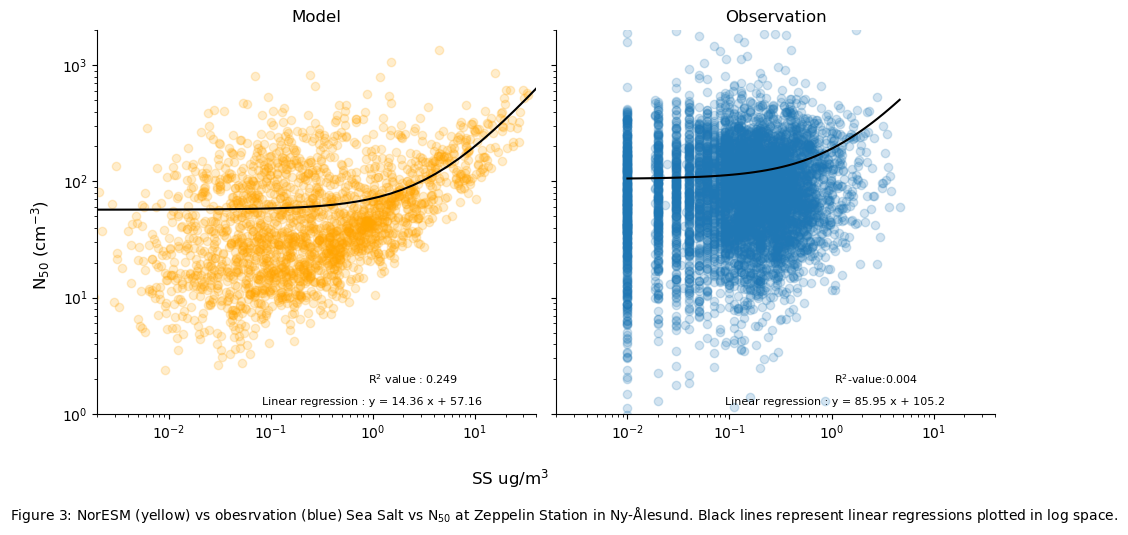

In [14]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1.2, 'Linear regression : y = 14.36 x + 57.16' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
ax1.text(0.9, 1.8, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N50']].dropna('time')
ax2.scatter(x=_dss['SS'], y=_dss['N50'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'], _dss['N50'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 1.2, 'Linear regression : y = 85.95 x + 105.2' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'])
r_sq = model.score(x, _dss['N50'])
ax2.text(1.05, 1.8, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(1,2000)
ax2.set_xlim(0.002,40)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
ax2.set_title(f'Observation')
f.supxlabel('SS ug/m$^3$')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 3: NorESM (yellow) vs obesrvation (blue) Sea Salt vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

Figure 4 shows sea salt concentrations against N100 concentrations in NorESM and observations. Since sea salt concentrations are being plotted here as well as in figure 3, the same striation at low concentrations and general clustering around median concentrations (0.14 ug/m3) is present. However, it is interesting to note that the r$^2$ value for the model data is 2 times greater when comparing SS to N100 instead of N50. In the observations, due to the fact that the r-squared value is still close to 0, it could be interpreted as the line of best fit having been drawn nearly randomly.

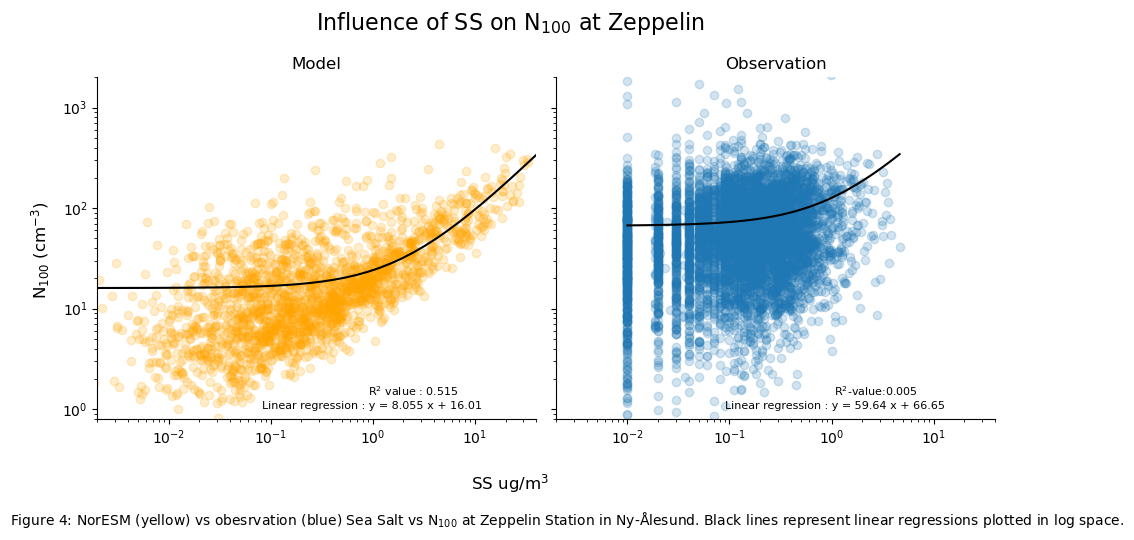

In [71]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1, 'Linear regression : y = 8.055 x + 16.01' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
ax1.text(0.9, 1.35, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N100']].dropna('time')
ax2.scatter(x=_dss['SS'], y=_dss['N100'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'], _dss['N100'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 1, 'Linear regression : y = 59.64 x + 66.65' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'])
r_sq = model.score(x, _dss['N100'])
ax2.text(1.05, 1.35, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.8,2000)
ax2.set_xlim(0.002,40)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
ax2.set_title(f'Observation')
f.suptitle('Influence of SS on N$_{100}$ at Zeppelin', fontsize=16)
f.supxlabel('SS ug/m$^3$')
f.supylabel('N$_{100}$ (cm$^{-3}$)')
f.text(0, -0.05,
         'Figure 4: NorESM (yellow) vs obesrvation (blue) Sea Salt vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

When only analysing observation data from 2020, when the new instruments started to be used, the pattern is vastly different from that already shown. The randomness of the line is completely removed as the r-squared value is now nearly identical to that of the model data. Additionally, relationship between SO4 and N50 is also nearly identical between the two datasets. This is makes the model seem far more accurate in terms of modelling the processes leading to CCN formation. However, there are issues that arise when analysing at the other variables (Supplementary figures 3,4,5). The relationship between N100 and SO4 in the observations is now no longer matching the model data, instead it is two times larger. When comparing N50 and N100 to sea salt, the relationship in the model and in the observation are now nearly identical, however they are still equally random with an r-squared value close to zero.

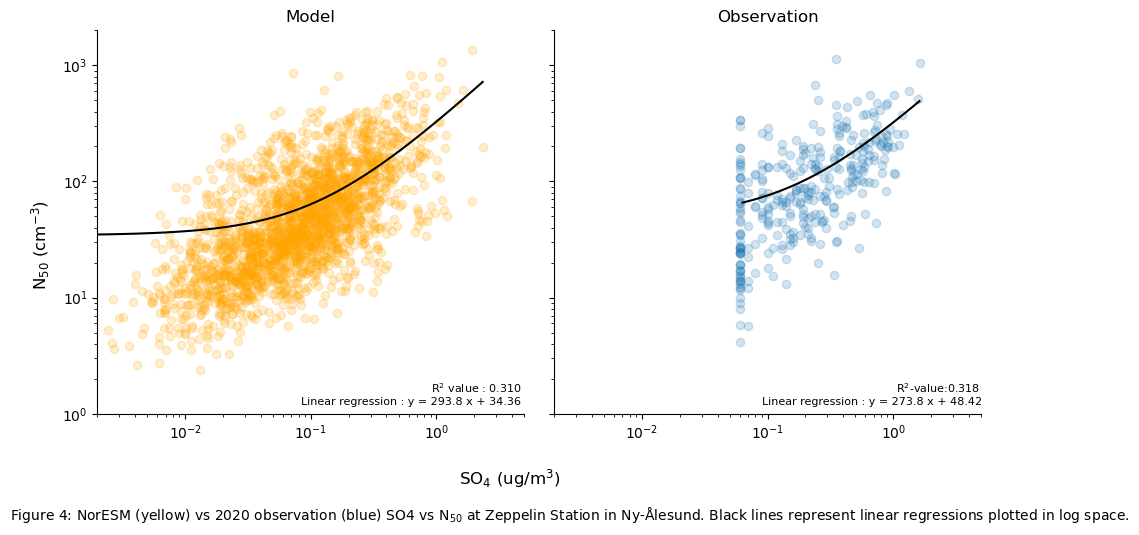

In [72]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SO4_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1.2, 'Linear regression : y = 293.8 x + 34.36' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
ax1.text(0.9, 1.5, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)
ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N50']].dropna('time')
ax2.scatter(x=_dss['SO4'].sel(time=slice('2020-01','2022-12')), y=_dss['N50'].sel(time=slice('2020-01','2022-12')), alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'].sel(time=slice('2020-01','2022-12')), _dss['N50'].sel(time=slice('2020-01','2022-12')), 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].sel(time=slice('2020-01','2022-12')).max()))
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 1.2, 'Linear regression : y = 273.8 x + 48.42' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4'].sel(time=slice('2020-01','2022-12'))]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
r_sq = model.score(x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
ax2.text(1.05, 1.5, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(1,2000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
ax2.set_title(f'Observation')
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 4: NorESM (yellow) vs 2020 observation (blue) SO4 vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

### 3.2 Accuracy of NorESM

In order to determine how accurately NorESM models the day to day conditions at Zeppelin, each data variable was compared to the daily averages of the same date in the measurement data. In the sulphate, N50 and N100 concentrations, datapoints have a tendency to be below the 1:1 line. Sea salt concentrations appear to be above the 1:1 line. This same pattern is seen in the slopes of the linear regressions all falling below 1. For sea salt, most datapoints are above the 1:1 line and similarly the slope of the linear regression is above 1. It is good to note that the axes of the sulphate comparison scatterplot have minima that are different by a magnitude of 2 orders. This is why the 1:1 line may look quite different from the other scatterplots. The aerosol properties in the data do not agree well with the observation data, which still occurs despite the model winds being nudged. This means that one would expect them to agree more if the sources/emissions are correctly modeled. This not being the case suggests that there might be errors in the emissions, though it may also be due to daily variability not being captured in the model.

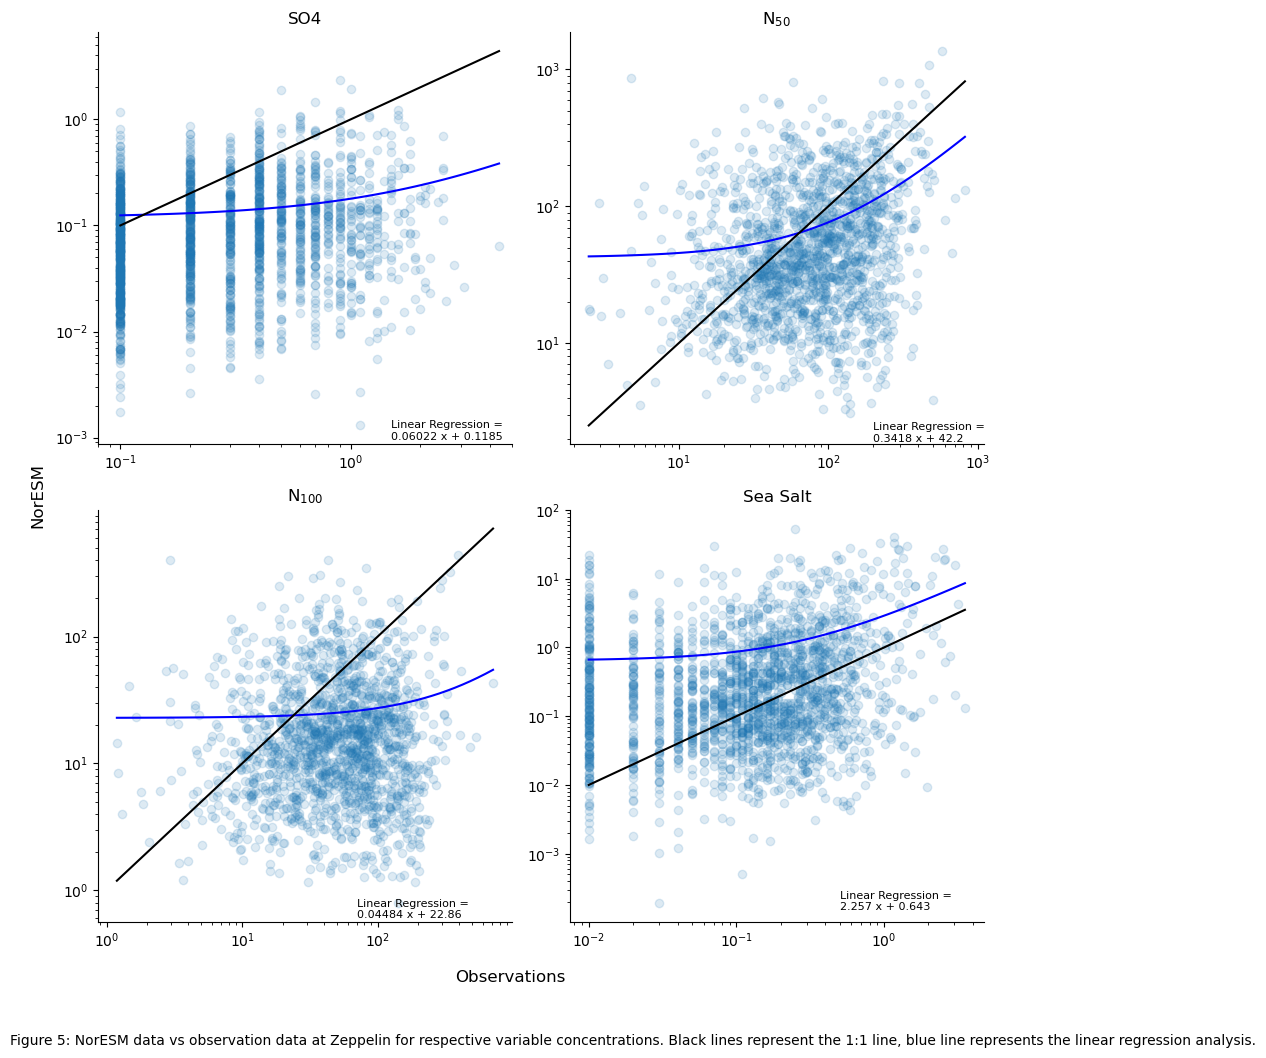

In [68]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout= True, figsize = (10,10))

ax1.scatter(x = ALLDATA['SO4'], y = ALLDATA['SO4_Model'],alpha = 0.15)
_dss = ALLDATA.to_dataframe().dropna()
z = np.polyfit(_dss['SO4'], _dss['SO4_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-1, np.log10(_dss['SO4'].max()))
ax1.plot( x, p(x), c = 'blue', )
ax1.plot( x, x, c = 'black', )
ax1.text(1.5, 0.00095, f"Linear Regression = {p}"  ,fontsize=8)

ax1.set_xlim(0.08,5)
ax1.set_title ('SO4')
ax1.set_yscale ('log')
ax1.set_xscale ('log')

ax2.scatter(x = ALLDATA['N50'], y = ALLDATA['N50_Model'],alpha = 0.15)
z = np.polyfit(_dss['N50'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N50'].min()), np.log10(_dss['N50'].max()))
ax2.plot( x, p(x), c = 'blue', )
ax2.plot( x, x, c = 'black', )
ax2.text(200.0, 1.9, f"Linear Regression = {p}"  ,fontsize=8)

ax2.set_title ('N$_{50}$')
ax2.set_yscale ('log')
ax2.set_xscale ('log')

ax3.scatter(x = ALLDATA['N100'], y = ALLDATA['N100_Model'],alpha = 0.15)
z = np.polyfit(_dss['N100'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N100'].min()), np.log10(_dss['N100'].max()))
ax3.plot( x, p(x), c = 'blue', )
ax3.plot( x, x, c = 'black', )
ax3.text(70.0, 0.6, f"Linear Regression = {p}"  ,fontsize=8)

ax3.set_title ('N$_{100}$')
ax3.set_yscale ('log')
ax3.set_xscale ('log')

ax4.scatter(x = ALLDATA['SS'], y = ALLDATA['SS_Model'],alpha = 0.15)
z = np.polyfit(_dss['SS'], _dss['SS_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
ax4.plot( x, p(x), c = 'blue', )
ax4.plot( x, x, c = 'black', )
ax4.text(0.5, 0.00015, f"Linear Regression = {p}"  ,fontsize=8)

ax4.set_title ('Sea Salt')
ax4.set_yscale ('log')
ax4.set_xscale ('log')

f.supxlabel('Observations')
f.supylabel('NorESM')
f.text(0, -0.05,
         'Figure 5: NorESM data vs observation data at Zeppelin for respective variable concentrations. Black lines represent the 1:1 line, blue line represents the linear regression analysis.')

sns.despine()

***

## 4. Discussion

Sulphate is important in making CCN's through coating and particle growth, which in turn is important for cloud droplet formation. We can see that the model also acknowledges this role of sulphate in particle number, however, it seems to overestimate the influence of sulphate's role. This is because whilst the slope of the model data for sulphate vs N100 is similar to that in the observation data (Figure 2), when including smaller particle sizes (N50) the slope of the model data is more than 2.5 times higher than that of the observation data (Figure 1). Additionally, the fairly good r-squared values of around 0.31 for the linear regression (given the complicated nature of particle formation), suggests that sulphate is a main reason for the trend seen in the model. The observation data does not show this as the r-squared values are nearly 0, representing complete randomness. It is assumed that this is due to the influence of outliers as well as the striation caused by the instrument's low measuring resolution.

When analysing how the model represents sea salt, it would be expected for sea salt to have a clearer influence on the N100 than N50 concentration, given that sea salt particles are usually slightly larger. NorESM represents this quite accurately since the r-squared value of the linear regression increases from 0.249 to 0.515 when comparing sea salt to N50 and N100 respectively. The observation data however shows little difference in the correlation as in both N50 as well as N100, the r-squared value is nearly 0. This means that the linear regression is nearly random. Assuming that this poor regression coefficient is due to the striation of the data, the relationship of sea salt to either particle size is still curious. The divergence in the slopes of the model and observation data is greater when plotting SS against N100, compared to against N50. This means that despite the model correctly identifying sea salt's increased role in the formation of larger particles, it underestimates even more the number of large particles being created. When looking at N100, this could be due to NorESM producing too many large sea salt aerosols. Since a too high concentration of sodium would be distributed across fewer particles than would normally be expected, the particles that are present must on average be larger. This in turn would cause these larger particles to be activated at lower super saturations, leading to earlier cloud formation and a greater negative forcing from clouds.

Directly comparing NorESM values to observation values for each variable indicated that NorESM underestimated the concentrations of all variables with the exception of sea salt. However, for sea salt, total sea salt mass (ie. NaCl rather than just sodium), which would then result in the  For N100, this underestimation seems only slight as many of the datapoints fall close to the 1:1 line. Since the sulphate concentrations role in N100 concentrations is accurately modelled, a lack of sulphate, would also lead to a lack of N100. However, the role of sea salt particles also need to be observed. Sea salt particles are course and therefore influence N100 greatly. Since their concentrations are overestimated, this could balance out the underestimation resulting from sulphate concentrations being too low. When it comes to CCN production, this could still be problematic as it would result in the correct number of particles, due to incorrect reasons. This can lead to further errors in the model regarding the correct composition of particles. This is similar for concentrations of N50, which seem to be underestimated in the model despite the influence of sulphates on N50 concentrations being too high. In this case, the underestimation of sulphate concentrations on a day to day basis does not balance out the overestimation of its role in N50 concentration. Leading to not enough small particles. 

It is important to note that a strong limitation of this investigation is the banded striation visible in most of the obesrvation data. This can be explained when plotting SO4 on its own, see supplementary figure 1. Despite the observation data being daily averages, the concentrations seem to become grouped into increments of 0.1 ug/m3 for SO4 and 0.01 ug/m3 for sea salt. This is the main reason for why the r-squared values are very low in the observation data as the concentrations that would be between these increments are not accurately measured. Comparing the model data to observations with a higher measurement resolution results in the model matching quite accurately in the relationship of all variables except N100 against SO4. The fact that there is no temporal overlap in the datasets when doing this, along with the observation data only consisting of one year worth of measurements, makes this analysis inappropriate. However, with further data using the higher resolution, the model may be representing the processes of CCN formation quite accurately assuming that the same relationships still appear (with the expection of SO4).

## 5. Conclusion

Whilst NorESM does take many intricate processes into account that lead to the formation of aerosols and eventually clouds, many of these processes are not modelled as accurately as they could when looking at the Arctic. Concentrations of sulphate are too low on a day-to-day basis. NorESM overestimates the correlation of nearly all variables as seen in the regression coefficients of the observation data being always close to 0 indicating randomness. This is due to the sampling resolution. NorESM also overestimates the relationship of sulphate concentration on N50 concentration. Some of these errors balance out (eg. the overestimation of sea salt concentrations paired with the underestimation of particle numbers of sea salt aerosols), however, the eventual influence on cloud formation processes could be important. Errors in particle sizes could have a knock-on effect with incorrect numbers of CCN's being activated, thereby influencing the optical properties of the clouds and changing the radiative balance for a very sensitive region of the earth.

## 6. Sources


* Lin, G., Wan, H., Zhang, K., Qian, Y., &amp; Ghan, S. J. (2016). Can nudging be used to quantify model sensitivities in precipitation and cloud forcing? Journal of Advances in Modeling Earth Systems, 8(3), 1073–1091. https://doi.org/10.1002/2016ms000659 

* Mauritsen, T., Sedlar, J., Tjernström, M., Leck, C., Martin, M., Shupe, M., Sjogren, S., Sierau, B., Persson, P. O., Brooks, I. M., &amp; Swietlicki, E. (2011). An arctic CCN-limited cloud-aerosol regime. Atmospheric Chemistry and Physics, 11(1), 165–173. https://doi.org/10.5194/acp-11-165-2011 

* Pithan, F., &amp; Mauritsen, T. (2014). Arctic amplification dominated by temperature feedbacks in contemporary climate models. Nature Geoscience, 7(3), 181–184. https://doi.org/10.1038/ngeo2071 

* Schmale, J., Zieger, P., &amp; Ekman, A. M. (2021). Aerosols in current and future arctic climate. Nature Climate Change, 11(2), 95–105. https://doi.org/10.1038/s41558-020-00969-5 

* Screen, J. A., &amp; Simmonds, I. (2010). The central role of diminishing sea ice in recent Arctic temperature amplification. Nature, 464(7293), 1334–1337. https://doi.org/10.1038/nature09051 

* Serreze, M. C., &amp; Barry, R. G. (2011). Processes and impacts of Arctic amplification: A research synthesis. Global and Planetary Change, 77(1-2), 85–96. https://doi.org/10.1016/j.gloplacha.2011.03.004 

* Zelinka, M. D., Klein, S. A., Taylor, K. E., Andrews, T., Webb, M. J., Gregory, J. M., &amp; Forster, P. M. (2013). Contributions of different cloud types to feedbacks and rapid adjustments in CMIP5*. Journal of Climate, 26(14), 5007–5027. https://doi.org/10.1175/jcli-d-12-00555.1 

## 7. Acknowledgements

Special thanks to Sara for lots of advice and guidance regarding coding and understanding of scientific background. Thank you to Michael Schulz and Paul Zieger for organizing this course which has already greatly increased my coding abilities, which will help a lot in any future projects of mine that include data processing of large datasets.

### 8. Supplementary

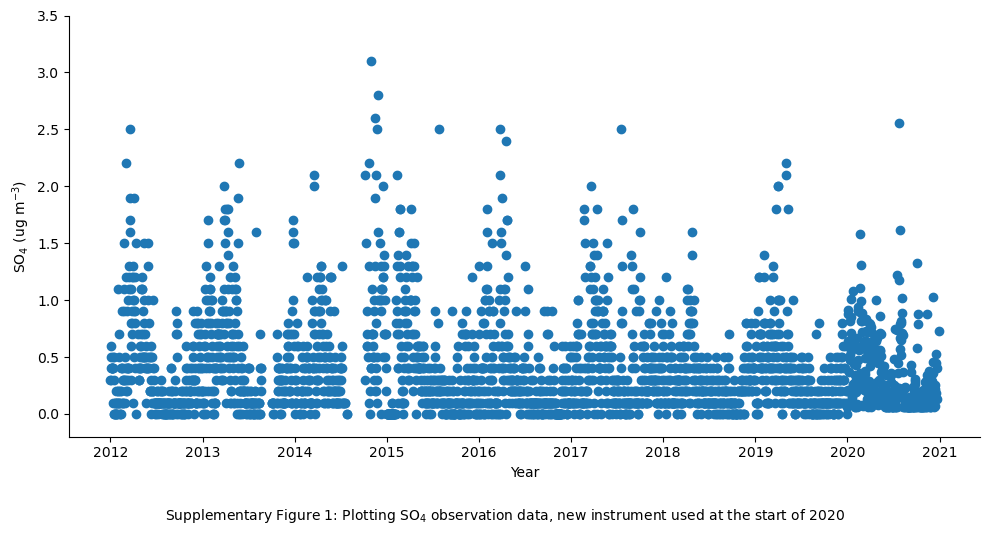

In [24]:
f, (ax1) = plt.subplots(1,tight_layout=True, figsize = (10,5))


#_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x= ALLDATA['time'].sel(time=slice('2012-01','2022-12')), y = ALLDATA['SO4'].sel(time=slice('2012-01','2022-12')))
ax1.set_ylim(-0.2,3.5)
ax1.set_ylabel('SO$_4$ (ug m$^{-3}$)')
ax1.set_xlabel('Year')

f.text(0.17, -0.05,
         'Supplementary Figure 1: Plotting SO$_4$ observation data, new instrument used at the start of 2020')

sns.despine()

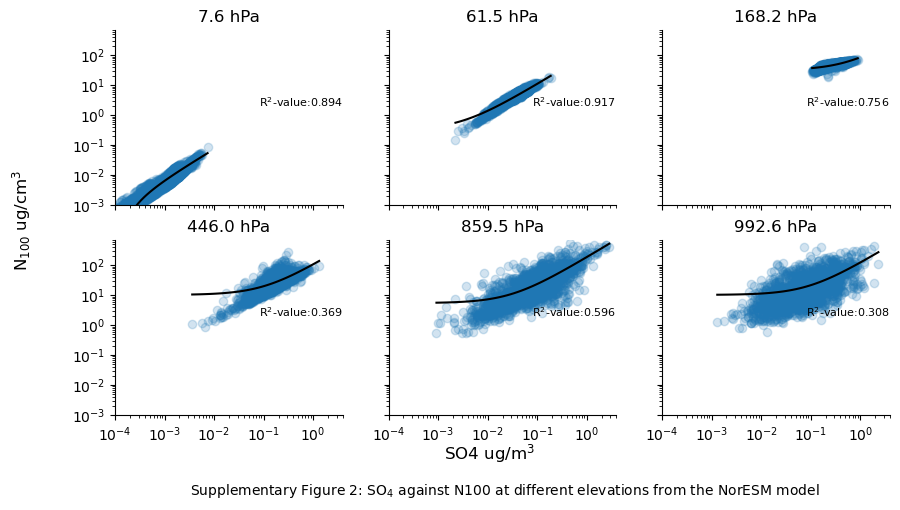

In [17]:
Levels = ds_daily.sel(location = 'Zeppelin').isel(lev= [-31,-25,-19,-13,-7,-1])
Levels = Levels.load()

fig, axs = plt.subplots(2,3, figsize = [10,5], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(Levels['lev'], axs.flatten()):
    #print(lev)
    _dss = Levels.where(Levels['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_Model'], y=_dss['N100'], alpha = 0.2 )
    z = np.polyfit(_dss['SO4_Model'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
    ax.plot( x, p(x), c = 'black', )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_ylim ([0.001,700])
    ax.set_xlim ([0.0001,4])
    
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(f'{lev.values:.1f} hPa')
    
    #Calculating R-Squared
    x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N100'])
    r_sq = model.score(x, _dss['N100'])
    ax.text(0.08, 2, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)

    
fig.supxlabel('SO4 ug/m$^3$')
fig.supylabel('N$_{100}$ ug/cm$^3$')

fig.text(0.2, -0.05,
         'Supplementary Figure 2: SO$_4$ against N100 at different elevations from the NorESM model')

sns.despine(fig)

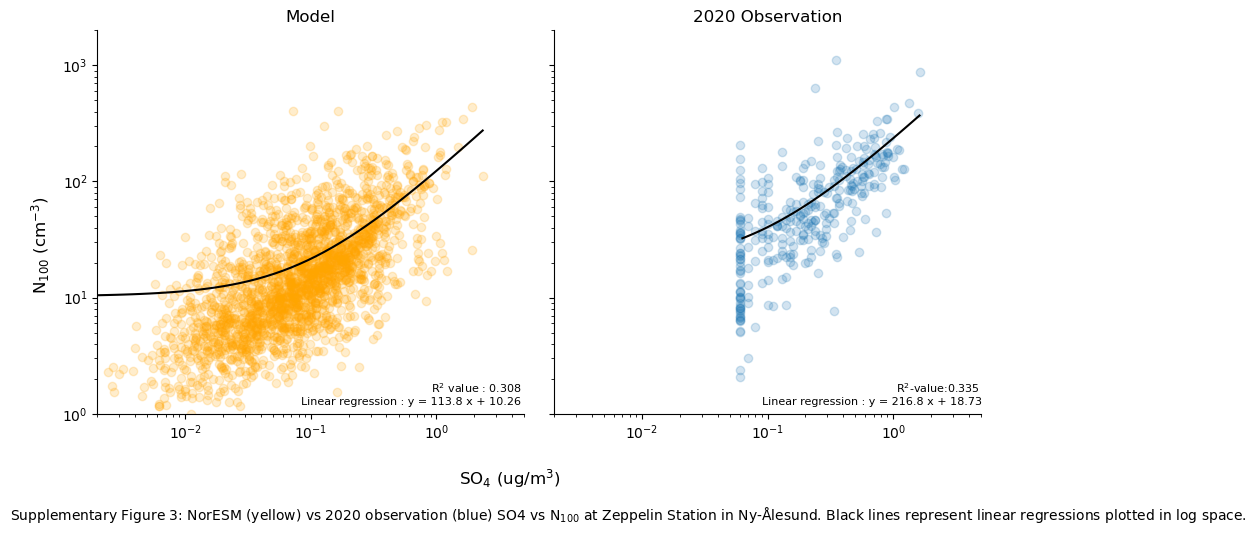

In [53]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 1.2, 'Linear regression : y = 113.8 x + 10.26' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 1.5, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(1,2000)
ax1.set_xlim(0.002,5)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SO4 ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N100']].dropna('time')
ax2.scatter(x=_dss['SO4'].sel(time=slice('2020-01','2022-12')), y=_dss['N100'].sel(time=slice('2020-01','2022-12')), alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'].sel(time=slice('2020-01','2022-12')), _dss['N100'].sel(time=slice('2020-01','2022-12')), 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].sel(time=slice('2020-01','2022-12')).max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 1.2, 'Linear regression : y = 216.8 x + 18.73' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4'].sel(time=slice('2020-01','2022-12'))]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'].sel(time=slice('2020-01','2022-12')))
r_sq = model.score(x, _dss['N100'].sel(time=slice('2020-01','2022-12')))
#print(r_sq)
ax2.text(1.05, 1.5, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(1,2000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SO4 ug/m$^3$')
#plt.ylabel('N100 ')
ax2.set_title(f'2020 Observation')
#f.suptitle('Influence of SO4 on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{100}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Supplementary Figure 3: NorESM (yellow) vs 2020 observation (blue) SO4 vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)


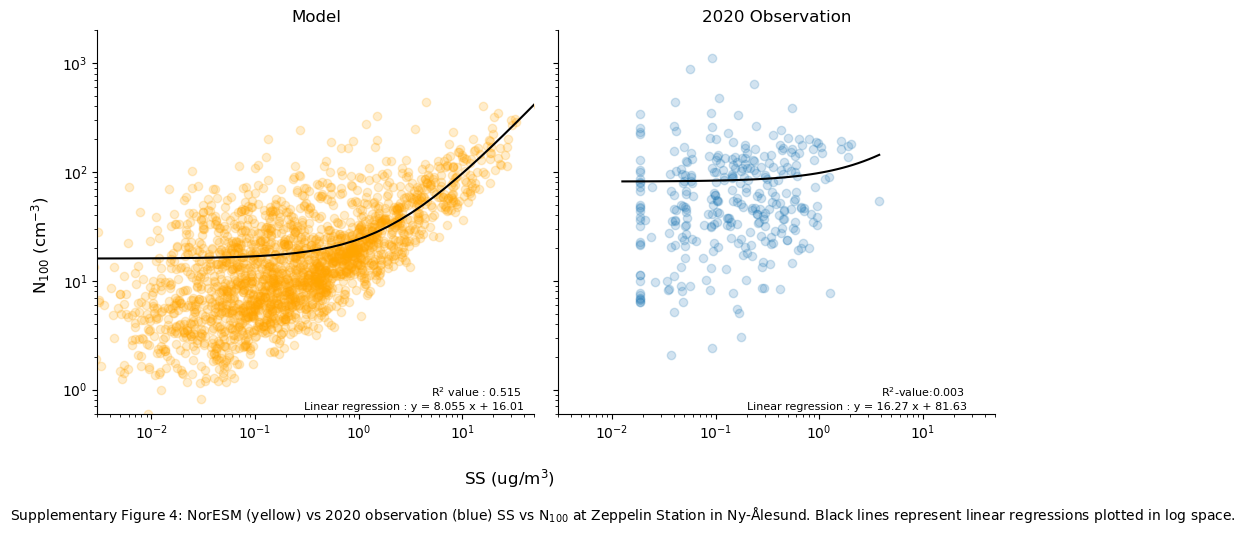

In [64]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.3, 0.65, 'Linear regression : y = 8.055 x + 16.01' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(5, 0.85, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.6,2000)
ax1.set_xlim(0.003,50)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SS ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N100']].dropna('time')
ax2.scatter(x=_dss['SS'].sel(time=slice('2020-01','2022-12')), y=_dss['N100'].sel(time=slice('2020-01','2022-12')), alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'].sel(time=slice('2020-01','2022-12')), _dss['N100'].sel(time=slice('2020-01','2022-12')), 1)
p = np.poly1d(z)
x= np.logspace(-1.9, np.log10(_dss['SS'].sel(time=slice('2020-01','2022-12')).max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.2, 0.65, 'Linear regression : y = 16.27 x + 81.63' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS'].sel(time=slice('2020-01','2022-12'))]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'].sel(time=slice('2020-01','2022-12')))
r_sq = model.score(x, _dss['N100'].sel(time=slice('2020-01','2022-12')))
#print(r_sq)
ax2.text(4, 0.85, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.6,2000)
ax2.set_xlim(0.003,50)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SS ug/m$^3$')
#plt.ylabel('N100 ')
ax2.set_title(f'2020 Observation')
#f.suptitle('Influence of SS on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SS (ug/m$^3$)')
f.supylabel('N$_{100}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Supplementary Figure 4: NorESM (yellow) vs 2020 observation (blue) SS vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

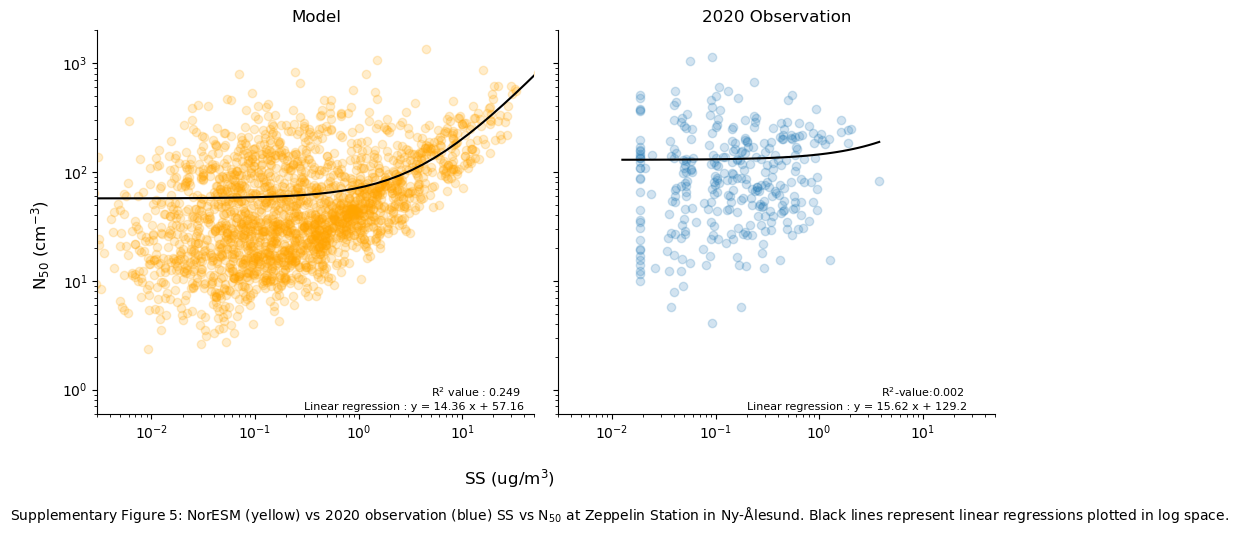

In [67]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.3, 0.65, 'Linear regression : y = 14.36 x + 57.16' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(5, 0.85, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.6,2000)
ax1.set_xlim(0.003,50)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SS ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N50']].dropna('time')
ax2.scatter(x=_dss['SS'].sel(time=slice('2020-01','2022-12')), y=_dss['N50'].sel(time=slice('2020-01','2022-12')), alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'].sel(time=slice('2020-01','2022-12')), _dss['N50'].sel(time=slice('2020-01','2022-12')), 1)
p = np.poly1d(z)
x= np.logspace(-1.9, np.log10(_dss['SS'].sel(time=slice('2020-01','2022-12')).max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.2, 0.65, 'Linear regression : y = 15.62 x + 129.2' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS'].sel(time=slice('2020-01','2022-12'))]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
r_sq = model.score(x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
#print(r_sq)
ax2.text(4, 0.85, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.6,2000)
ax2.set_xlim(0.003,50)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SS ug/m$^3$')
#plt.ylabel('N50 ')
ax2.set_title(f'2020 Observation')
#f.suptitle('Influence of SS on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SS (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Supplementary Figure 5: NorESM (yellow) vs 2020 observation (blue) SS vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)